**Adjustments Made to the Varaibles**

- Removed columns with over 80% missing values

- Alter categorical columns to have the mode of their column as their missing value

- For missing garage year buildt feature values I just coined it the same as the year built

- Alter numerical columns to have their missing values as the mean of their column

- Dropped any columns with a little correlation with the salesprice varaible

- Numerical columns with a lot of outliers were adjusted to have proper boundries to fill outliers

In [1]:
#Import Packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV, cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.exceptions import FitFailedWarning
import copy
import warnings

In [2]:
#Reading in the Data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
#Merged the for data processing
merged_data = pd.concat([train,test],ignore_index=True)

In [5]:
#Id is not necessary for predictions (Will bring it back to make final submission df)
merged_data = merged_data.drop(columns=['Id'])

In [6]:
len(train)

1460

In [7]:
len(test)

1459

In [8]:
len(merged_data)

2919

In [9]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   int64  
 1   MSZoning       2915 non-null   object 
 2   LotFrontage    2433 non-null   float64
 3   LotArea        2919 non-null   int64  
 4   Street         2919 non-null   object 
 5   Alley          198 non-null    object 
 6   LotShape       2919 non-null   object 
 7   LandContour    2919 non-null   object 
 8   Utilities      2917 non-null   object 
 9   LotConfig      2919 non-null   object 
 10  LandSlope      2919 non-null   object 
 11  Neighborhood   2919 non-null   object 
 12  Condition1     2919 non-null   object 
 13  Condition2     2919 non-null   object 
 14  BldgType       2919 non-null   object 
 15  HouseStyle     2919 non-null   object 
 16  OverallQual    2919 non-null   int64  
 17  OverallCond    2919 non-null   int64  
 18  YearBuil

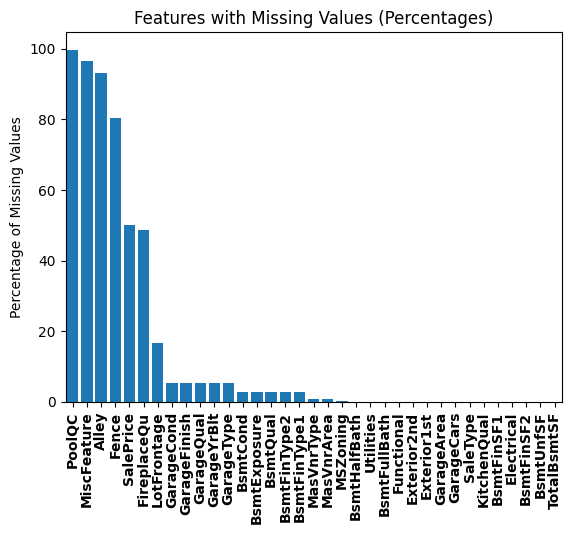

In [10]:
#Getting Table to show Percentages of Missing Values for each Column
total_missing_vals = merged_data.isnull().sum().sort_values(ascending=False)
percent = ((merged_data.isnull().sum()/merged_data.isnull().count())*100).sort_values(ascending=False)
missing_data = pd.concat([total_missing_vals, percent], axis=1, keys=['Total','Percent'])
missing_data_for_graph = missing_data[missing_data['Total'] > 0]
plt.figure()
bar_plot = plt.bar(missing_data_for_graph.index, height=missing_data_for_graph['Percent'])
plt.xticks(rotation=90, fontweight='bold')
plt.xlim(left=-0.5, right=len(missing_data_for_graph.index)-0.5)
plt.ylabel('Percentage of Missing Values')
plt.title('Features with Missing Values (Percentages)')
plt.show()

In [11]:
#Dropping any feature wtih more than 80% of missing values (Keeping SalePrice since it is missing within test set that is the predictions)
high_missing_values = []
for c in merged_data.columns:
    percent = (merged_data[c].isnull().sum()/ len(merged_data)*100)
    if c == 'SalePrice':
                continue
    if percent > 80.0:
                merged_data = merged_data.drop(columns=[c])
                high_missing_values.append(c)

In [12]:
high_missing_values

['Alley', 'PoolQC', 'Fence', 'MiscFeature']

In [13]:
#Feature Enginerring 
merged_data['TotalSF'] = merged_data['TotalBsmtSF'] + merged_data['1stFlrSF'] + merged_data['2ndFlrSF']
merged_data['HouseAge'] = merged_data['YrSold'] - merged_data['YearBuilt']
merged_data['RemodAge'] = merged_data['YrSold'] - merged_data['YearRemodAdd']
merged_data['Overall_rate_qual+cont'] = merged_data['OverallQual'] + merged_data['OverallCond']
merged_data['total_bathrooms'] = (merged_data['HalfBath']*.5) + merged_data['BsmtFullBath'] + (merged_data['BsmtHalfBath']*.5) + merged_data['FullBath']
merged_data['combined_deck_porch_sq'] = (merged_data['WoodDeckSF'] + merged_data['OpenPorchSF'] + 
                                        merged_data['3SsnPorch'] + merged_data['EnclosedPorch'])
merged_data['quantity_premium_add_ons'] = merged_data.apply(lambda row: (1 if row['WoodDeckSF'] != 0 else 0) +
                                                                       (1 if row['OpenPorchSF'] != 0 else 0) +
                                                                       (1 if row['PoolArea'] != 0 else 0) +
                                                                       (1 if row['3SsnPorch'] != 0 else 0) +
                                                                       (1 if row['EnclosedPorch'] != 0 else 0) +
                                                                       (1 if row['Fireplaces'] != 0 else 0), axis=1)

In [14]:
merged_data.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,TotalSF,HouseAge,RemodAge,Overall_rate_qual+cont,total_bathrooms,combined_deck_porch_sq,quantity_premium_add_ons
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,208500.0,2566.0,5,5,12,3.5,61,1
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,0,5,2007,WD,Normal,181500.0,2524.0,31,31,14,2.5,298,2
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,0,9,2008,WD,Normal,223500.0,2706.0,7,6,12,3.5,42,2
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml,140000.0,2473.0,91,36,12,2.0,307,3
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,0,12,2008,WD,Normal,250000.0,3343.0,8,8,13,3.5,276,3


In [15]:
categorical_columns = merged_data.select_dtypes(include='object').columns

In [16]:
len(categorical_columns)

39

In [17]:
# Get categorical columns that have missing values and fill them with the mode of their repsective column
for c in categorical_columns:
    if merged_data[c].isnull().any():
        mode_values = merged_data[c].mode()
        if not mode_values.empty:
            mode_value = mode_values[0]
            merged_data[c].fillna(mode_value, inplace=True)

In [18]:
dict_mapping_categorical_cols = {}
for c in categorical_columns:
    unique_values = merged_data[c].unique()
    column_mapping = {value: index + 1 for index, value in enumerate(unique_values)}
    dict_mapping_categorical_cols[c] = column_mapping

In [19]:
for column, mapping in dict_mapping_categorical_cols.items():
    merged_data[column].replace(mapping, inplace=True)

In [20]:
missing_garageyrblt = merged_data['GarageYrBlt'].isnull()
merged_data.loc[missing_garageyrblt, 'GarageYrBlt'] = merged_data.loc[missing_garageyrblt, 'YearBuilt']
merged_data['GarageYrBlt'] = merged_data['GarageYrBlt'].astype(int)

In [23]:
numerical_cols = []
for c in merged_data:
    if c not in categorical_columns and c not in ['Id','SalePrice','YearBuilt','YearRemodAdd','GarageYrBlt', 'YrSold']:
        numerical_cols.append(c)

In [24]:
for c in numerical_cols:
    if merged_data[c].isnull().any():
        mean_value = merged_data[c].mean()
        merged_data[c].fillna(mean_value, inplace=True)

In [25]:
columns =[]
for i in merged_data:
    columns.append(i)

In [26]:
cors = merged_data.corr()['SalePrice'].sort_values(ascending=False)

In [27]:
cors

SalePrice                   1.000000
OverallQual                 0.790982
TotalSF                     0.782260
GrLivArea                   0.708624
GarageCars                  0.640409
total_bathrooms             0.631731
GarageArea                  0.623431
TotalBsmtSF                 0.613581
1stFlrSF                    0.605852
Overall_rate_qual+cont      0.594786
FullBath                    0.560664
TotRmsAbvGrd                0.533723
quantity_premium_add_ons    0.527221
YearBuilt                   0.522897
GarageYrBlt                 0.508043
YearRemodAdd                0.507101
MasVnrArea                  0.475210
Fireplaces                  0.466929
BsmtFinSF1                  0.386420
combined_deck_porch_sq      0.366204
LotFrontage                 0.334820
WoodDeckSF                  0.324413
2ndFlrSF                    0.319334
OpenPorchSF                 0.315856
HalfBath                    0.284108
LotShape                    0.267759
LotArea                     0.263843
B

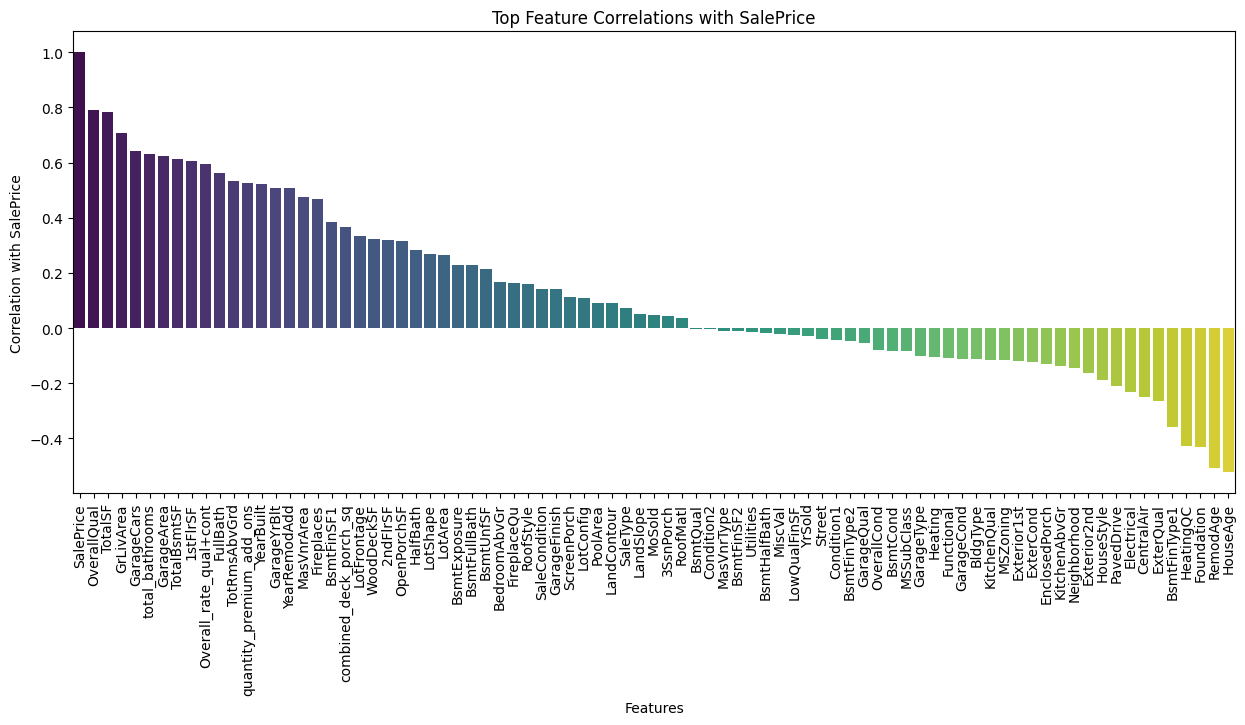

In [28]:
plt.figure(figsize=(15, 6))
sns.barplot(x=cors.index, y=cors, palette='viridis')
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Correlation with SalePrice')
plt.title('Top Feature Correlations with SalePrice')
plt.show()

In [29]:
#Keeping features that have a substanital correlation with saleprice (setting my cutoff at 0.2)
selected_features = []
for fea,cor in cors.items():    
       if abs(cor) >= 0.3 or cor < -0.3:
        selected_features.append(fea)
merged_data = merged_data[selected_features]

In [30]:
cors_v2 = merged_data.corr()['SalePrice'].sort_values(ascending=False)

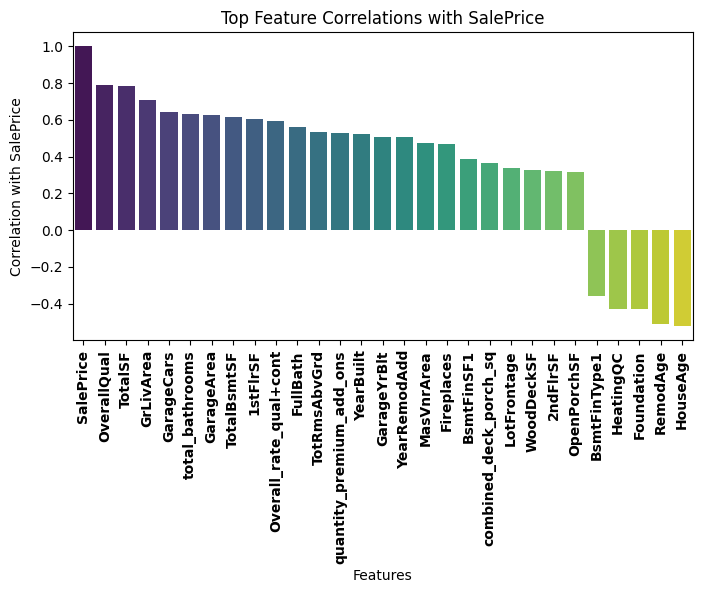

In [31]:
plt.figure(figsize=(8,4))
sns.barplot(x=cors_v2.index, y=cors_v2, palette='viridis')
plt.xticks(rotation=90, fontweight='bold')
plt.xlabel('Features')
plt.ylabel('Correlation with SalePrice')
plt.title('Top Feature Correlations with SalePrice')
plt.show()

In [32]:
#Altering columns with a lot of outliers by using bounds

In [46]:
def calculate_outlier_bound(df,column):
    q1 = df[column].quantile(0.25)
    q3=df[column].quantile(0.75)
    iqr=q3-q1
    lower_limit = q1-1.5*(iqr)
    upper_limit = q1+1.5*(iqr)
    df[column]=np.where(df[column]>upper_limit, upper_limit, df[column])
    df[column]=np.where(df[column]<lower_limit, upper_limit, df[column]) 

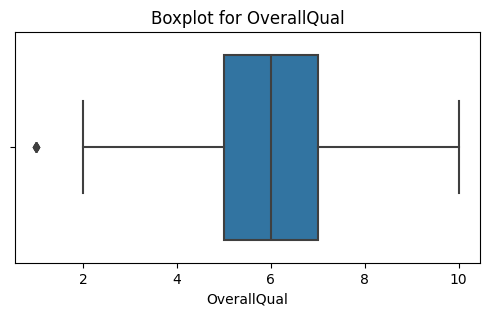

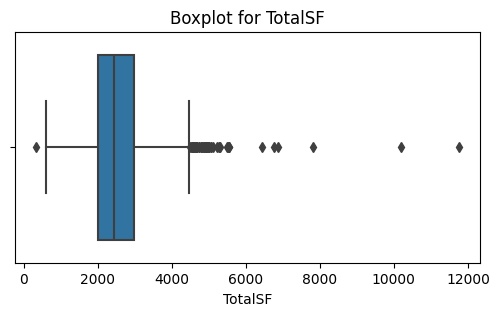

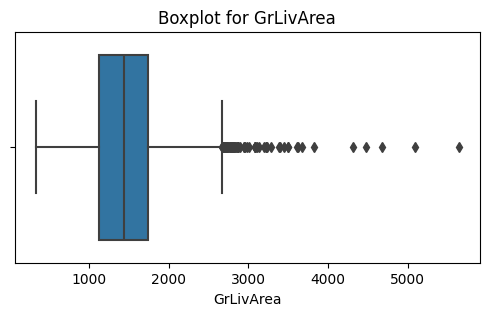

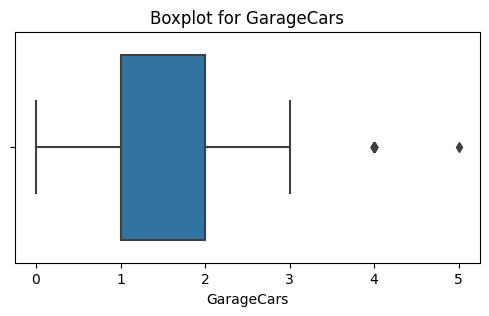

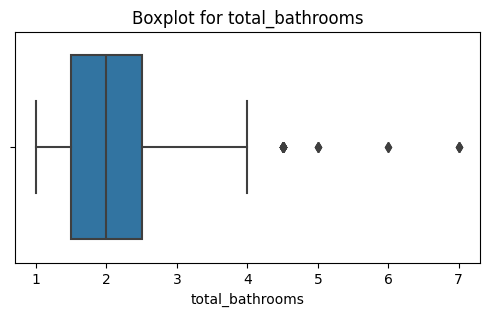

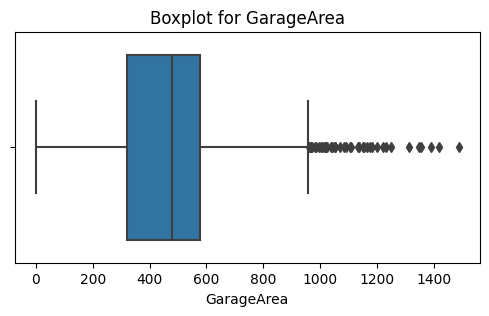

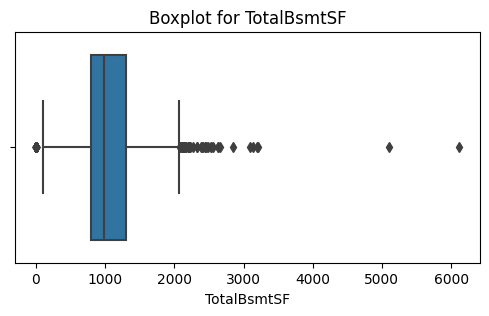

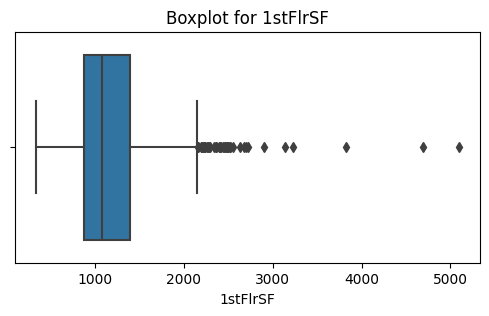

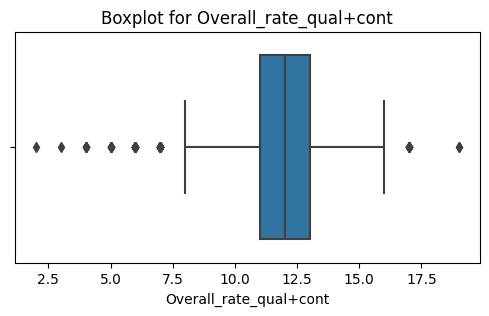

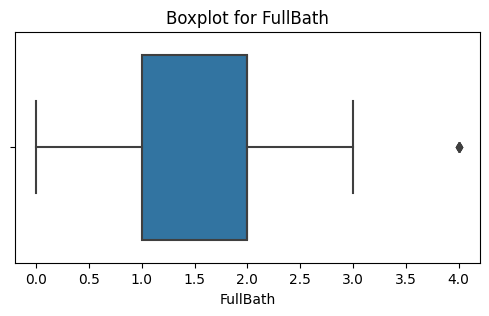

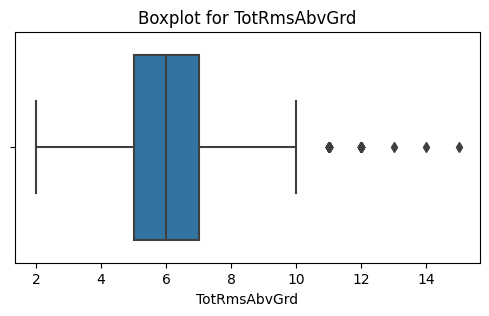

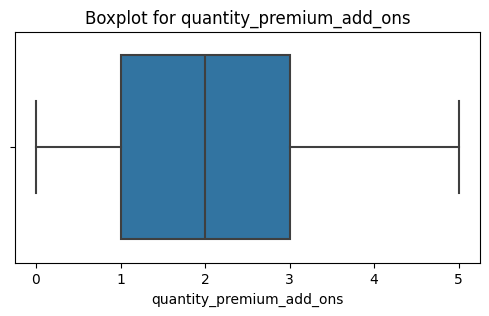

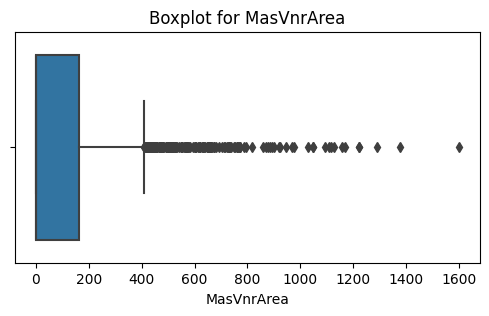

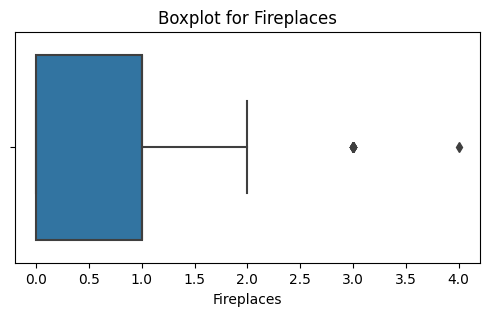

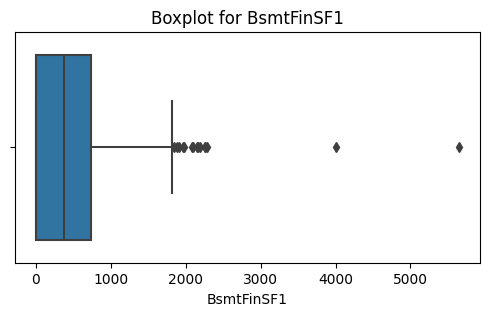

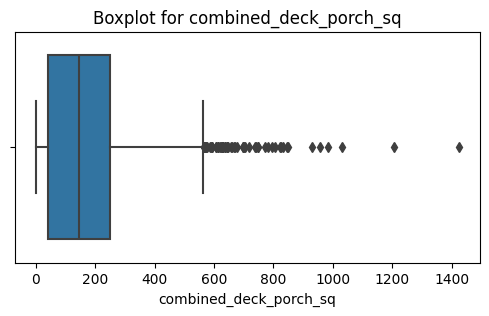

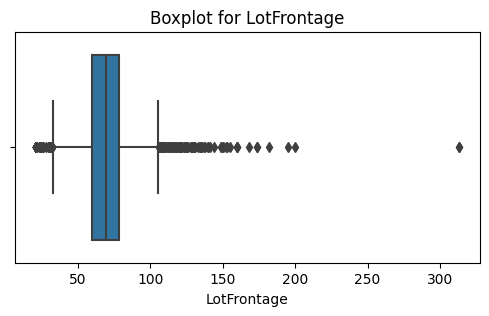

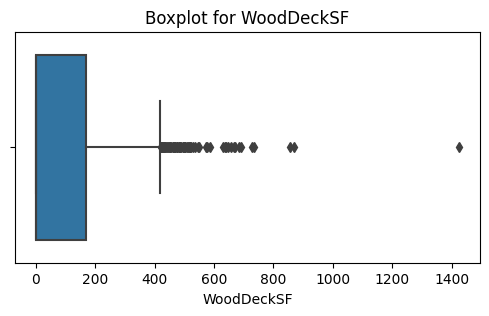

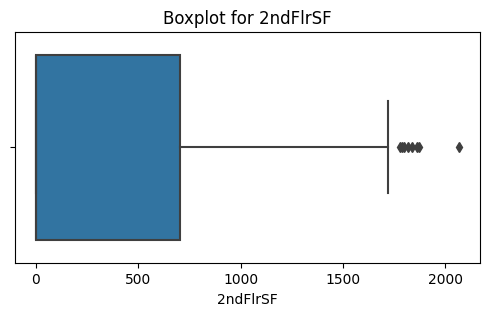

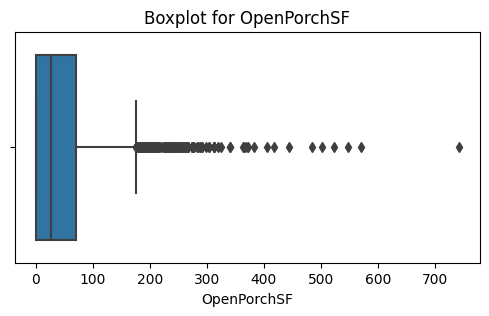

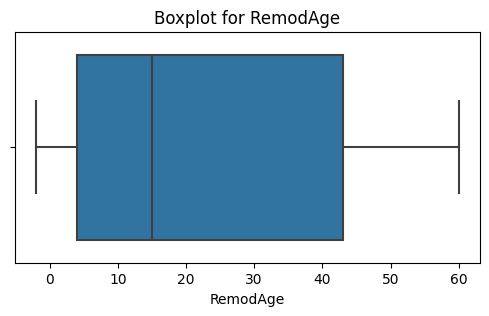

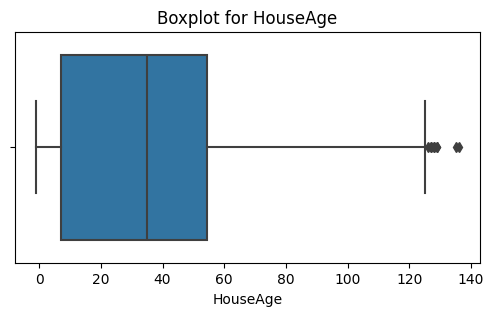

In [47]:
for col in merged_data.columns:
    if col in numerical_cols:
        plt.figure(figsize=(6,3))
        sns.boxplot(x=merged_data[col])
        plt.title(f"Boxplot for {col}")
        plt.show()

In [71]:
len(cols_major_outliers)

21

In [48]:
#Columns wihth noticebale outliers (Only for numerical columns, not categorical columns)
cols_major_ouatliers = ['LotFrontage','LotArea','MasVnrArea','BsmtUnfSF','TotalBsmtSF','1stFlrSF',
                      'GrLivArea','GarageArea','WoodDeckSF','OpenPorchSF','SalePrice', 'TotalSF', 'total_bathrooms',
                      'Overall_rate_qual+cont','TotRmsAbvGrd','BsmtFinSF1','combined_deck_porch_sq',
                      'ScreenPorch','EnclosedPorch','KitchenAbvGr','HouseAge']

In [49]:
cols_major_outliers_test = ['LotFrontage','MasVnrArea','TotalBsmtSF','1stFlrSF',
                      'GrLivArea','GarageArea','WoodDeckSF','OpenPorchSF','SalePrice', 'TotalSF', 'total_bathrooms',
                      'Overall_rate_qual+cont','TotRmsAbvGrd','BsmtFinSF1','combined_deck_porch_sq',
                      'HouseAge']

In [50]:
for i in cols_major_outliers_test:
    calculate_outlier_bound(merged_data,i)

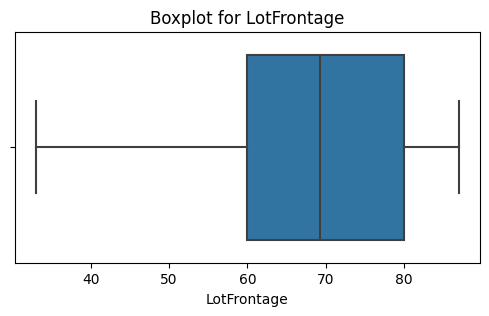

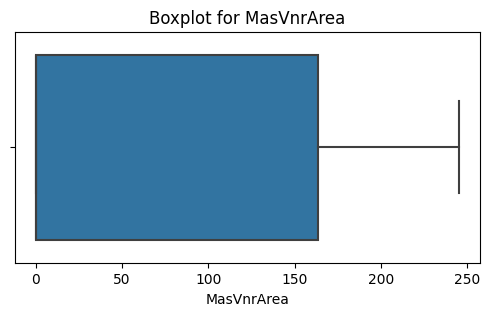

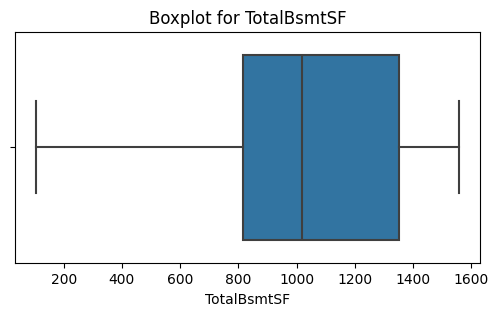

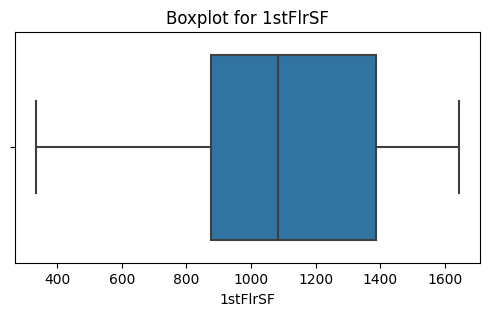

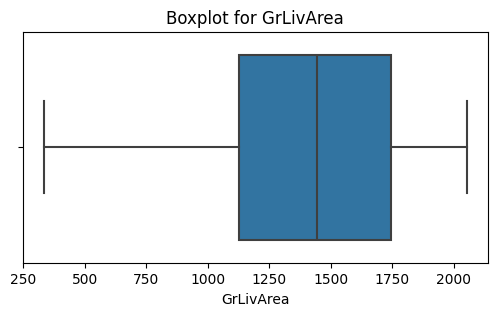

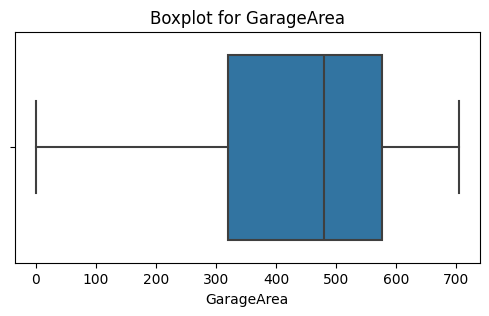

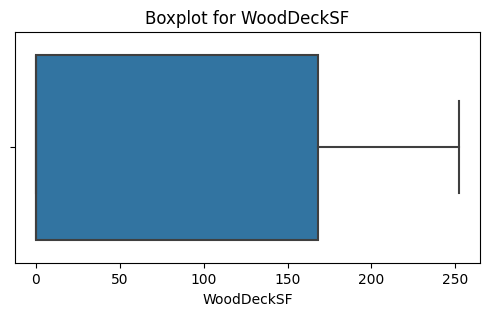

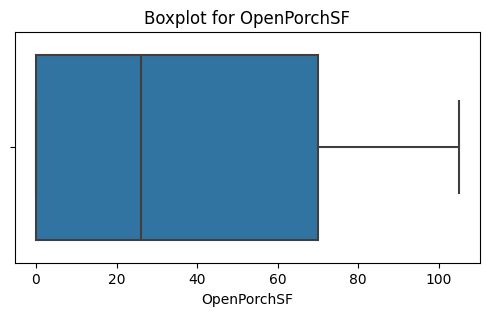

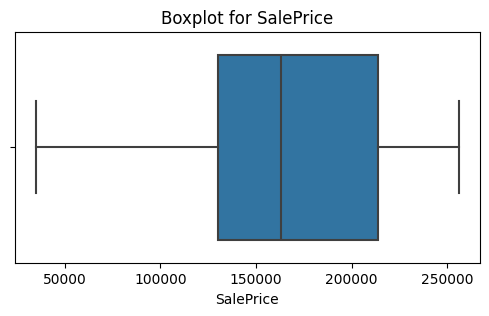

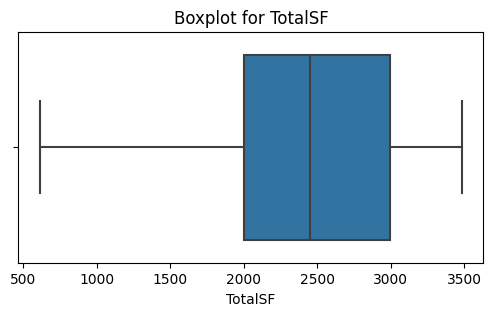

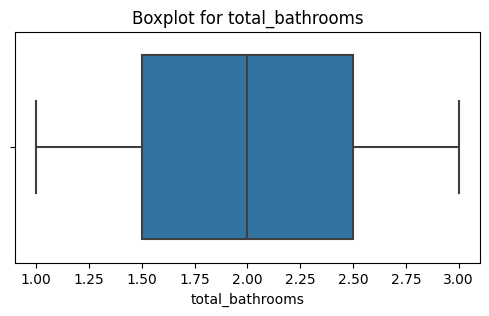

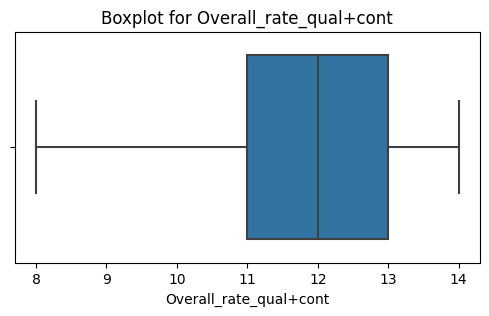

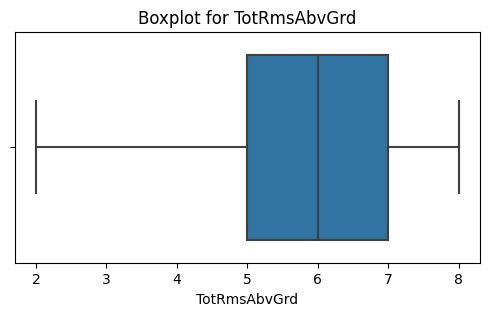

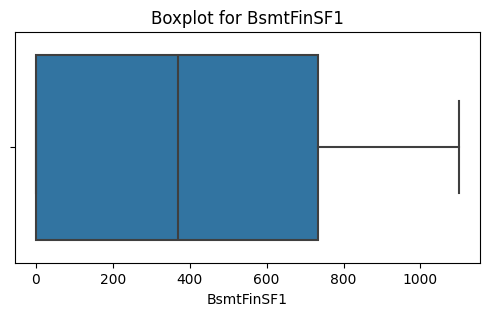

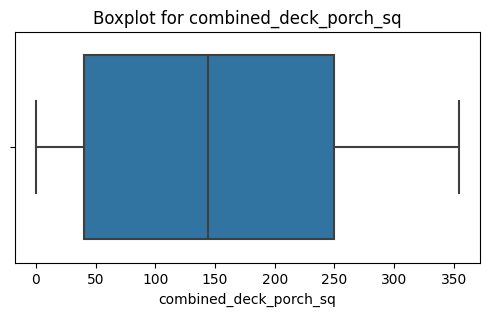

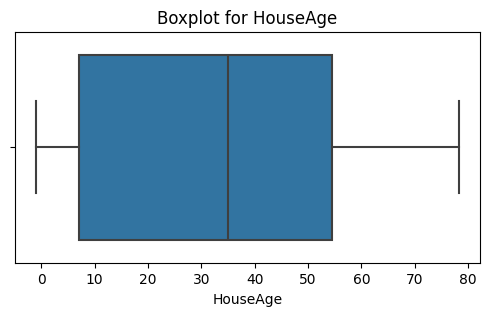

In [51]:
for col in cols_major_outliers_test:
    if col in categorical_columns:
        continue
    else:
        plt.figure(figsize=(6,3))
        sns.boxplot(x=merged_data[col])
        plt.title(f"Boxplot for {col}")
        plt.show()

In [52]:
len_train = len(train)

In [53]:
train = merged_data.iloc[:len_train]
test = merged_data.iloc[len_train:]
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [54]:
X = train.drop(columns = ['SalePrice'])
y = train['SalePrice'].values
Xtest = test.drop(columns = ['SalePrice'])
ytest = test['SalePrice'].values

In [55]:
y = np.log1p(y)

In [56]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
Xtest = scaler.transform(Xtest)

In [57]:
X = pd.DataFrame(X, columns=train.drop(columns=['SalePrice']).columns)
Xtest = pd.DataFrame(Xtest, columns=test.drop(columns=['SalePrice']).columns)

In [58]:
params = {'loss': ['ls', 'lad', 'huber', 'quantile'],
          'learning_rate': [0.05, 0.1, 0.0175, 0.2, 0.3],
          'n_estimators': [100, 200, 300, 400, 500],
          'min_samples_split': [2, 3, 5, 7, 9, 10],
          'min_samples_leaf': [1, 2, 3, 4, 5, 6],
          'max_depth': [5, 6, 7, 8, 10, 12],
          'max_features': ['auto', 'sqrt', 'log2'],
          'alpha': [0.0, 0.1, 0.5, 1.0]}

In [59]:
boost = GradientBoostingRegressor()

In [60]:
ran_cv = RandomizedSearchCV(estimator=boost, param_distributions=params,
                            n_jobs=-1, cv=5, n_iter=100, verbose=3, scoring='neg_mean_squared_error')

In [61]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", FitFailedWarning)
    ran_cv.fit(X, y)
print(ran_cv.best_estimator_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


C:\Users\ekroo\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:979: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan -0.02581688         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan -0.01850196         nan         nan
         nan -0.01583125         nan         nan         nan         nan
         nan         nan         nan         nan -0.02314168         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan -0.0164539          nan
         nan -0.01535915 -0.01682258         nan -0.01763872         nan
 -0.01536586         nan         nan         nan -0.01585112         nan
         nan         nan         nan -0.01537113         nan -0.01561922
         nan         nan         nan         nan      

GradientBoostingRegressor(alpha=0.1, loss='huber', max_depth=5,
                          max_features='log2', min_samples_leaf=2,
                          min_samples_split=10, n_estimators=200)


In [62]:
best_params = ran_cv.best_params_
boost_random_cv = GradientBoostingRegressor(**best_params)
boost_random_cv.fit(X, y)

GradientBoostingRegressor(alpha=0.1, loss='huber', max_depth=5,
                          max_features='log2', min_samples_leaf=2,
                          min_samples_split=10, n_estimators=200)

In [63]:
feature_importance_gb = boost_random_cv.feature_importances_ * 100
rel_imp_gb = pd.Series(feature_importance_gb, index=X.columns).sort_values(ascending=False, inplace=False)[:20]

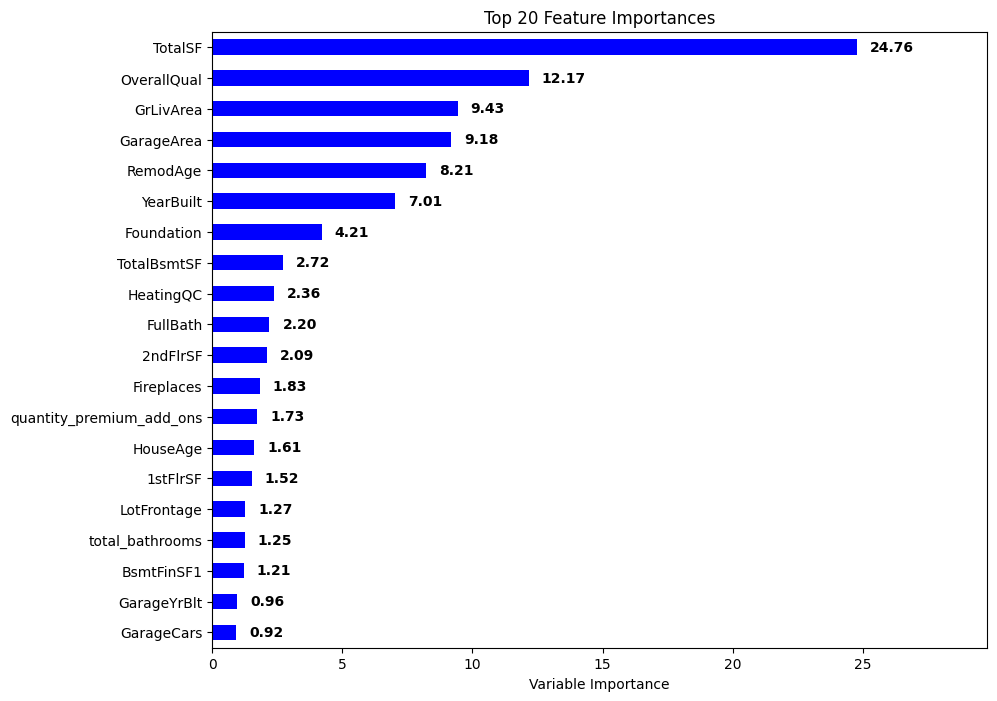

In [74]:
plt.figure(figsize=(10, 8))
ax = rel_imp_gb.plot(kind='barh', color='b')
ax.invert_yaxis()
plt.xlim(right=rel_imp_gb.max() + 5)
for i, v in enumerate(rel_imp_gb):
    ax.text(v + 0.5, i, f'{v:.2f}', color='black', va='center', fontweight='bold')
plt.xlabel('Variable Importance')
plt.title('Top 20 Feature Importances')
plt.show()

In [65]:
y_pred_gb = boost_random_cv.predict(Xtest)

In [66]:
y_pred_gb = np.expm1(y_pred_gb)

In [67]:
#Used to input the id's back for the final submission dataframe
test_ids = pd.read_csv('test.csv')

In [68]:
submission_df = pd.DataFrame({'Id': test_ids['Id'], 'SalePrice': y_pred_gb})
submission_df

,Id,SalePrice
0,1461,129215.109825
1,1462,155771.872848
2,1463,180591.800102
3,1464,193493.050309
4,1465,190893.758383
5,1466,177360.544408
6,1467,187097.408826
7,1468,170141.023938
8,1469,191791.164083
9,1470,121444.318620


In [963]:
submission_df.to_csv('housing_submission_v13.csv',index=False)

**More Graphics for Final Report**

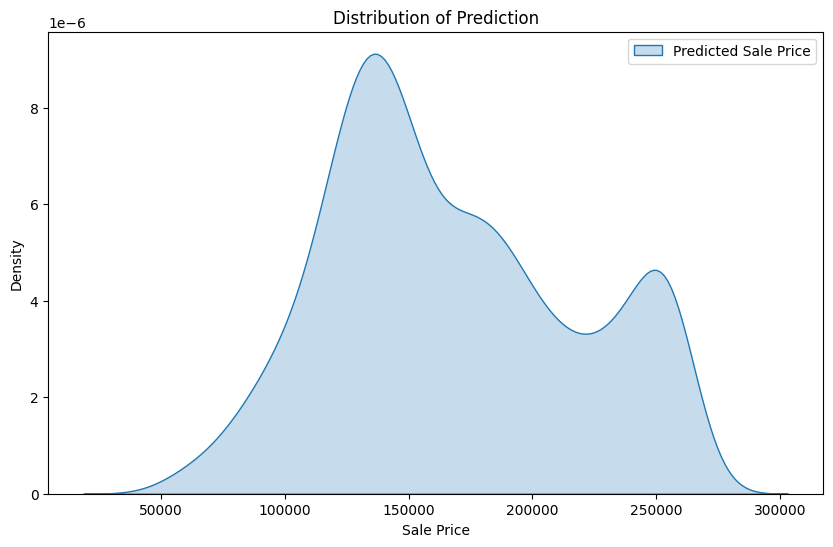

In [849]:
plt.figure(figsize=(10, 6))
sns.kdeplot(y_pred_gb, label='Predicted Sale Price', fill=True)
sns.kdeplot(ytest, label='Actual Sale Price', fill=True)
plt.title('Distribution of Prediction')
plt.xlabel('Sale Price')
plt.ylabel('Density')
plt.legend()
plt.show()

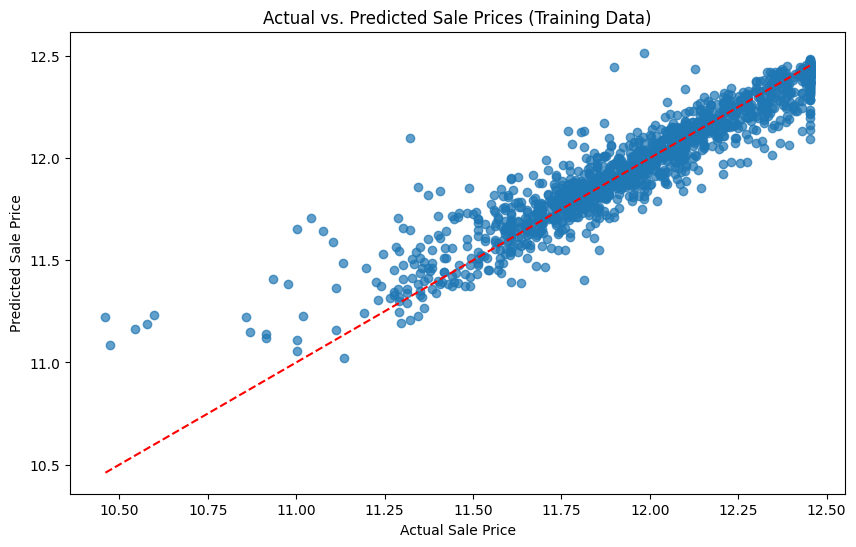

In [791]:
y_pred_train = cross_val_predict(boost_random_cv, X, y, cv=5)
plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred_train, alpha=0.7)
plt.plot([min(y), max(y)], [min(y), max(y)], color='red', linestyle='--')
plt.title('Actual vs. Predicted Sale Prices (Training Data)')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.show()

In [69]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
y_pred_train = boost_random_cv.predict(X)
y_train_original = np.expm1(y)
y_pred_train_original = np.expm1(y_pred_train)
r2_train = r2_score(y_train_original, y_pred_train_original)
print(f"R-squared on Training Set: {r2_train}")

R-squared on Training Set: 0.9552391294003855


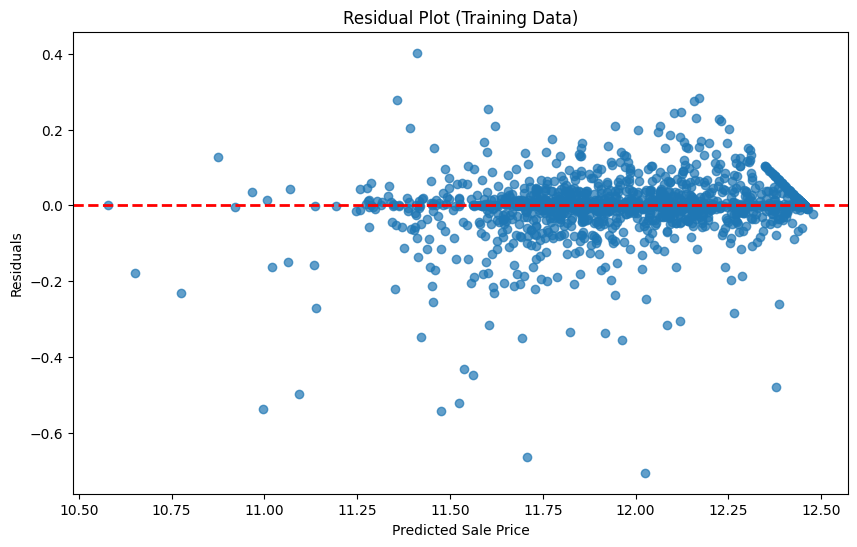

In [70]:
plt.figure(figsize=(10, 6))
residuals = y - y_pred_train
plt.scatter(y_pred_train, residuals, alpha=0.7)
plt.title('Residual Plot (Training Data)')
plt.xlabel('Predicted Sale Price')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.show()